<a href="https://colab.research.google.com/github/lOmarMisbahl/SpeachEmotionRecognition/blob/main/SpeachEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as confusion
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def ReadAudio(path):
    i=0
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            basename = os.path.basename(filename)
            emotion = emotion2int[basename.split("_")[2]]
            Emotions[i]=emotion
            samplerate, data = wavfile.read(os.path.join(dirname, filename))
            zero_crss_rate = ((data[:-1] * data[1:]) < 0).sum()
            data , sr = librosa.load(dirname+"/"+filename)
            S, phase = librosa.magphase(librosa.stft(data))
            Energies[i]=librosa.feature.rms(y=data,S=S)
            ZeroRates[i]=zero_crss_rate
            frequencies, times, spectrogram = signal.spectrogram(data, samplerate)
            DB = librosa.amplitude_to_db(spectrogram, ref=np.max)
            MelSpectrograms[i]=DB
            i=i+1          

In [ ]:
path="/content/drive/MyDrive/CREMA"
emotion2int = {
    "NEU": 1,
    "HAP": 2,
    "SAD": 3,
    "DIS": 4,
    "FEA": 5,
    "ANG": 6
}
Energies=dict.fromkeys(range(7498), [])
ZeroRates=np.zeros(7498,int)
Emotions=np.zeros(7498,int)
MelSpectrograms = dict.fromkeys(range(7498), [])
ReadAudio(path)

In [ ]:
# Resizing MelSpectrograms to the size of the largest
import cv2
import matplotlib.pyplot as plt

MelSpectrograms_rs= dict.fromkeys(range(7498), [])
for i in range(7498):
  MelSpectrograms_rs[i] = cv2.resize(MelSpectrograms[i],(357,129))
  

In [ ]:
#Energies=np.transpose(Energies)
#Energies=Energies.reshape(7498,1)
ZeroRates=np.transpose(ZeroRates)
ZeroRates=ZeroRates.reshape(7498,1)
Emotions=np.transpose(Emotions)
Emotions=Emotions.reshape(7498,1)
#FeatureSpace1= np.hstack((Energies,ZeroRates))

In [ ]:
def measure_f(grndtruth, y_predict):
  fmeasure=f1_score(grndtruth,y_predict,average='micro')
  print("The F-Measure Score is:\n",fmeasure)


In [ ]:
def split(featureSpace,labels,testRatio):
     X_train, X_test, y_train, y_test = train_test_split(featureSpace,labels,test_size=testRatio,shuffle=False)
     return X_train, X_test, y_train, y_test

In [ ]:
FeatureSpace1_Train,FeatureSpace1_Test,FeatureSpace1_TrainLabels,FeatureSpace1_TestLabels= split(Energies,Emotions,0.3)
FeatureSpace2_Train,FeatureSpace2_Test,FeatureSpace2_TrainLabels,FeatureSpace2_TestLabels= split(MelSpectrograms_rs,Emotions,0.3)

In [ ]:
print(np.shape(FeatureSpace2_Train))
print(np.shape(FeatureSpace2_Test))
print(np.unique(Emotions))


(5248, 129, 357)
(2250, 129, 357)
[1 2 3 4 5 6]


In [ ]:
FeatureSpace2_Train = np.array(FeatureSpace2_Train)
FeatureSpace2_Train = FeatureSpace2_Train[:,:,:,np.newaxis]
print(FeatureSpace2_Train.shape)
FeatureSpace2_Test = np.array(FeatureSpace2_Test)
FeatureSpace2_Test = FeatureSpace2_Test[:,:,:,np.newaxis]
print(FeatureSpace2_Test.shape)

(5248, 129, 357, 1)
(2250, 129, 357, 1)


In [ ]:
print(type(FeatureSpace2_Train[0][0][0][0]))
FeatureSpace2_Train = FeatureSpace2_Train.astype('float32')
FeatureSpace2_Test = FeatureSpace2_Test.astype('float32')
FeatureSpace2_Train = FeatureSpace2_Train / 255.
FeatureSpace2_Test = FeatureSpace2_Test / 255.
print(FeatureSpace2_Train[0][0][0][0])

<class 'numpy.float32'>
-0.063708134


In [ ]:
FeatureSpace2_Train = abs(FeatureSpace2_Train)
FeatureSpace2_Test = abs(FeatureSpace2_Test)
print(FeatureSpace2_Train[0][0][0][0])

0.063708134


In [ ]:
!pip install keras.utils
from tensorflow.keras.utils import to_categorical
FeatureSpace2_TrainLabels = FeatureSpace2_TrainLabels - 1
FeatureSpace2_TestLabels = FeatureSpace2_TestLabels - 1
train_Y_one_hot = to_categorical(FeatureSpace2_TrainLabels)
test_Y_one_hot = to_categorical(FeatureSpace2_TestLabels)
print('Original label:', FeatureSpace2_TrainLabels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=3f5d7b8de6faa8c13d768195c2597ae718e81d270347c4cd112db03391955ccd
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils
Original label: [4]
After conversion to one-hot: [0. 0. 0. 0. 1. 0.]


# 2D CNN

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
batch_size = 64
epochs = 20
num_classes = 6

In [ ]:
spectr_model = Sequential()
spectr_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(129,357,1),padding='same'))
spectr_model.add(LeakyReLU(alpha=0.1))
spectr_model.add(tf.keras.layers.Dropout(0.1))
spectr_model.add(MaxPooling2D((2, 2),padding='same'))

spectr_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
spectr_model.add(LeakyReLU(alpha=0.1))
spectr_model.add(tf.keras.layers.Dropout(0.1))
spectr_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

spectr_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
spectr_model.add(LeakyReLU(alpha=0.1)) 
spectr_model.add(tf.keras.layers.Dropout(0.1))                 
spectr_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

spectr_model.add(Flatten())

spectr_model.add(Dense(128, activation='linear'))
spectr_model.add(LeakyReLU(alpha=0.1))                  
spectr_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
spectr_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
spectr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 357, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 129, 357, 32)      0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 129, 357, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 179, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 179, 64)       18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 65, 179, 64)       0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 65, 179, 64)       0

In [ ]:
#validation split
X_dummy, valid_X , y_dummy, valid_label = split(FeatureSpace2_Train,train_Y_one_hot,0.05)
valid_X = np.array(valid_X)
valid_label = np.array(valid_label)
X_dummy = np.array(X_dummy)
y_dummy = np.array(y_dummy)
#validation_data=(valid_X, valid_label)
#print(type(validation_data))

In [ ]:
spectr_train = spectr_model.fit(X_dummy, y_dummy, batch_size=batch_size,epochs=epochs,
                                verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
78/78 [==============================] - 534s 7s/step - loss: 1.6307 - accuracy: 0.3155 - val_loss: 1.5664 - val_accuracy: 0.2928
Epoch 2/20
78/78 [==============================] - 521s 7s/step - loss: 1.5218 - accuracy: 0.3682 - val_loss: 1.5471 - val_accuracy: 0.3080
Epoch 3/20
78/78 [==============================] - 524s 7s/step - loss: 1.5384 - accuracy: 0.3576 - val_loss: 1.5824 - val_accuracy: 0.3080
Epoch 4/20
78/78 [==============================] - 530s 7s/step - loss: 1.5259 - accuracy: 0.3677 - val_loss: 1.6344 - val_accuracy: 0.2738
Epoch 5/20
78/78 [==============================] - 536s 7s/step - loss: 1.5259 - accuracy: 0.3702 - val_loss: 1.5332 - val_accuracy: 0.3042
Epoch 6/20
78/78 [==============================] - 534s 7s/step - loss: 1.5319 - accuracy: 0.3681 - val_loss: 1.5750 - val_accuracy: 0.2852
Epoch 7/20
78/78 [==============================] - 572s 7s/step - loss: 1.5075 - accuracy: 0.3737 - val_loss: 1.5717 - val_accuracy: 0.3118
Epoch 8/20
78

In [ ]:
spectr_model.save("/content/drive/MyDrive/spectr_model_no_dropout_v2.h5py")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/spectr_model_no_dropout_v2.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/spectr_model_no_dropout_v2.h5py/assets


In [ ]:
spectr_model_v2 = keras.models.load_model('/content/drive/MyDrive/spectr_model_no_dropout.h5py')

In [ ]:
test_eval = spectr_model.evaluate(FeatureSpace2_Test, test_Y_one_hot, verbose=1)
print('Test loss with dropout:', test_eval[0])
print('Test accuracy with dropout:', test_eval[1])
test_eval = spectr_model_v2.evaluate(FeatureSpace2_Test, test_Y_one_hot, verbose=1)
print('Test loss without dropout:', test_eval[0])
print('Test accuracy without dropout:', test_eval[1])

71/71 [==============================] - 60s 847ms/step - loss: 1.7048 - accuracy: 0.4107
Test loss with dropout: 1.7048466205596924
Test accuracy with dropout: 0.41066667437553406
71/71 [==============================] - 61s 851ms/step - loss: 51.3533 - accuracy: 0.1809
Test loss without dropout: 51.353302001953125
Test accuracy without dropout: 0.18088889122009277


In [ ]:
spectr_predict=spectr_model.predict(FeatureSpace2_Test,verbose=1)
spectr_predict_v2=spectr_model_v2.predict(FeatureSpace2_Test,verbose=1)
spectr_predict.shape

71/71 [==============================] - 61s 851ms/step


(2250, 6)

In [ ]:
spectr_predict_not_hot=spectr_predict.argmax(axis=1)
spectr_predict_v2_not_hot=spectr_predict_v2.argmax(axis=1)
test_Y_not_hot=test_Y_one_hot.argmax(axis=1)
print(np.unique(spectr_predict_not_hot))
print(np.unique(test_Y_not_hot))
measure_f(test_Y_not_hot,spectr_predict_not_hot)
measure_f(test_Y_not_hot,spectr_predict_v2_not_hot)
#print(spectr_predict[80])

[0 1 2 3 4 5]
[0 1 2 3 4 5]
The F-Measure Score is:
 0.4106666666666666
The F-Measure Score is:
 0.18088888888888888


In [ ]:
confusion_spectr = confusion(test_Y_not_hot, spectr_predict_not_hot)
confusion_spectr_v2 = confusion(test_Y_not_hot, spectr_predict_v2_not_hot)
print(confusion_spectr)

[[190  38  59  22  19   1]
 [ 91 145  21  31  61  35]
 [ 80  17 244  24  23   1]
 [ 96  75 119  38  37  19]
 [ 74  74  92  12  95  36]
 [ 30  75   5  15  44 212]]


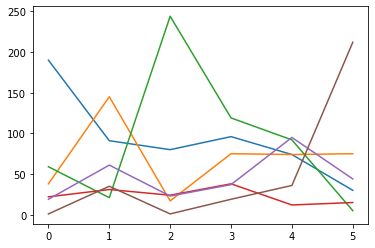

In [ ]:
plt.plot(confusion_spectr)
plt.show()

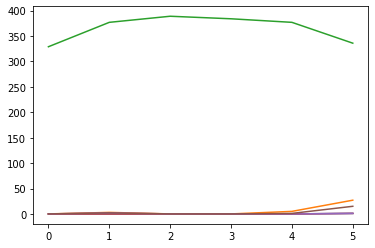

In [ ]:
plt.plot(confusion_spectr_v2)
plt.show()

In [ ]:
i=0
j=0
for i in range(len(test_Y_not_hot)):
  if(test_Y_not_hot[i]==2):
    j=j+1
print(j)

389


# 1D CNN

In [ ]:
EnergiesReshaped= dict.fromkeys(range(7498), [])
for i in range(7498):
  EnergiesReshaped[i] = cv2.resize(Energies[i],(1,216))

Train,Test,TrainLabels,TestLabels= split(EnergiesReshaped,Emotions,0.3)
Train = np.array(Train)
Test = np.array(Test)
Train = Train.astype('float32')
Test = Test.astype('float32')
#Train = Train / 255.
#Test = Test / 255.
Train = abs(Train)
Test = abs(Test)

TrainLabels = TrainLabels - 1
TestLabels = TestLabels - 1
TrainHot = to_categorical(TrainLabels)
TestHot = to_categorical(TestLabels)
#TrainSqueezed=np.squeeze(Train)

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=Train[0].shape))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(6))
model.add(tf.keras.layers.Activation('softmax'))
model.compile(optimizer=Adam(lr=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 64)           704       
_________________________________________________________________
activation (Activation)      (None, 216, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 54, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 54, 64)            41024     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 64)            0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_m, train_val , hot_m, hot_val = split(Train,TrainHot,0.05)
train_m= np.array(train_m)
train_val= np.array(train_val)
hot_m= np.array(hot_m)
hot_val= np.array(hot_val)

In [ ]:
Energy_Model_train = model.fit(train_m, hot_m, batch_size=64,epochs=100,verbose=1,validation_data=(train_val, hot_val))

Epoch 1/100
78/78 [==============================] - 8s 86ms/step - loss: 1.6556 - accuracy: 0.2879 - val_loss: 1.6963 - val_accuracy: 0.2433
Epoch 2/100
78/78 [==============================] - 6s 75ms/step - loss: 1.6233 - accuracy: 0.3069 - val_loss: 1.6896 - val_accuracy: 0.2471
Epoch 3/100
78/78 [==============================] - 6s 74ms/step - loss: 1.6146 - accuracy: 0.3117 - val_loss: 1.7341 - val_accuracy: 0.2319
Epoch 4/100
78/78 [==============================] - 6s 73ms/step - loss: 1.6155 - accuracy: 0.3091 - val_loss: 1.6892 - val_accuracy: 0.2586
Epoch 5/100
78/78 [==============================] - 6s 75ms/step - loss: 1.6136 - accuracy: 0.3119 - val_loss: 1.7012 - val_accuracy: 0.2624
Epoch 6/100
78/78 [==============================] - 6s 76ms/step - loss: 1.6230 - accuracy: 0.3077 - val_loss: 1.6888 - val_accuracy: 0.2852
Epoch 7/100
78/78 [==============================] - 6s 72ms/step - loss: 1.6129 - accuracy: 0.3103 - val_loss: 1.6918 - val_accuracy: 0.2548
Epoch 

In [ ]:
test_eval_1D = model.evaluate(Test, TestHot, verbose=1)
print('Test loss:', test_eval_1D[0])
print('Test accuracy:', test_eval_1D[1])

In [ ]:
energy_predict=model.predict(Test,verbose=1)

energy_predict_not_hot=energy_predict.argmax(axis=1)
TestnotHot=TestHot.argmax(axis=1)
print(np.unique(energy_predict_not_hot))
print(np.unique(TestnotHot))
measure_f(TestnotHot,energy_predict_not_hot)

71/71 [==============================] - 1s 7ms/step
[0 1 2 5]
[0 1 2 3 4 5]
The F-Measure Score is:
 0.3151111111111111


In [ ]:
confusion_energy = confusion(TestnotHot, energy_predict_not_hot)
print(confusion_energy)

[[151  72 103   0   0   3]
 [105 163  50   0   0  66]
 [122  31 233   0   0   3]
 [124  82 146   0   0  32]
 [ 99 113 103   0   0  68]
 [ 75 115  29   0   0 162]]


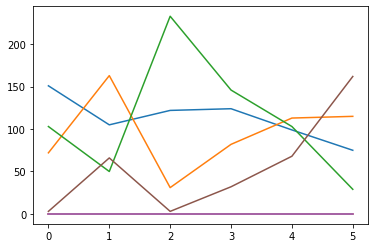

In [ ]:
plt.plot(confusion_energy)
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/1D.h5py")